# Info 

Author: Xiaoqian Sun <br>
Created: 08/2023 <br>
Function: Apply Peeling algorithm on the simulated calcium trace generated in `1.1-poissonSpikes_saveArray.ipynb` to infer spikes. <br>

In [5]:
import os 
import time
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Functions import *
from simuParams import simuParams
from simulation import Simulation
from peelParams import peelParams
from peelReconstruction import peelReconstr

import warnings
warnings.filterwarnings('ignore')

/Users/xiaoqiansun/opt/anaconda3/lib/python3.8/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [6]:
# file path
root_path = os.getcwd()
data_path = os.path.join(root_path, 'Poisson_CaImAnTest')

# parameters
dur = 10
cellNum = 10
frameRate = 30
dims = (512, 512)



# Load Simulation Obj

simuObj  loaded
dff.shape: (300, 10)

simuPara[nIdex]: {'ca_genmode': 'linDFF', 'A1': 8.0, 'tau1': 0.5, 'A2': 0, 'tau2': 1, 'tauOn': 0.01, 'ca_amp': 7100, 'ca_amp1': 0, 'ca_tau1': 0, 'ca_rest': 50, 'ca_gamma': 400, 'ca_kappas': 100, 'ca_onsettau': 0.02, 'dffmax': 93, 'noiseSD': 2.4166689210856345, 'kd': 250, 'kappab': 138.88888888888889, 'spk_recmode': 'linDFF'}

neuron spkTimes groundTruth: [5.0000e-03 6.8100e-02 1.2650e-01 2.7420e-01 3.9610e-01 5.5330e-01
 8.7180e-01 1.0903e+00 1.4908e+00 2.5110e+00 2.7139e+00 3.2527e+00
 3.3356e+00 4.7284e+00 4.7427e+00 4.8827e+00 5.6554e+00 5.7263e+00
 6.1718e+00 7.1973e+00 8.2136e+00 8.6422e+00 8.9195e+00 8.9284e+00
 9.0177e+00 9.7807e+00 9.9326e+00]



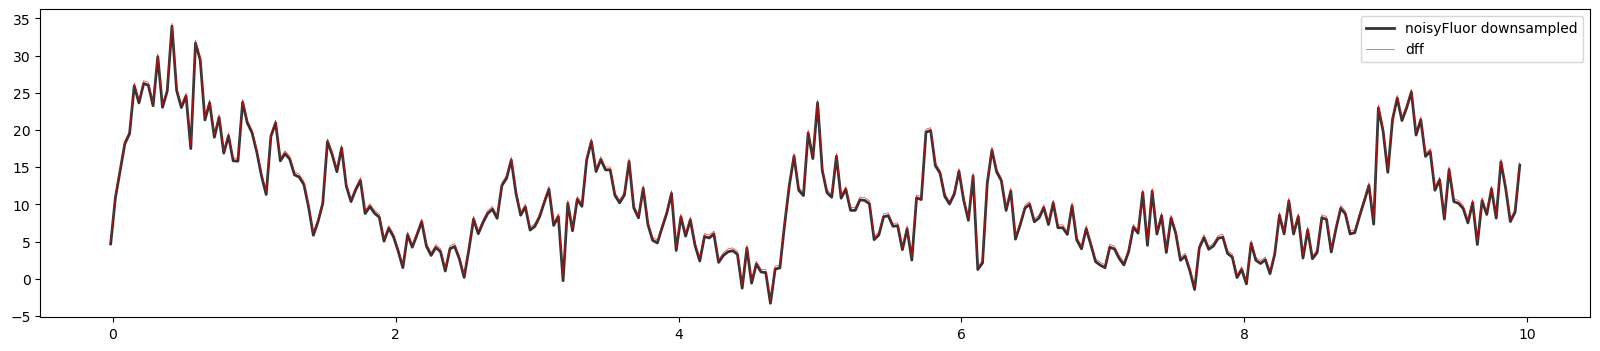

In [21]:
with open(os.path.join(data_path,'simulation_Object.pkl'), 'rb') as fp:
    simuObj = pickle.load(fp)
    print('simuObj  loaded')


# extract simuPara from simuPbj
simuPara = simuObj.params
xSampled = simuObj.xSampled  # time steps [-0.01666667,  0.01666667,  0.05,..., 9.91666667,  9.95 ]


# simulated dff
dff = pd.DataFrame(simuObj.sampledFluor).T
print('dff.shape:',dff.shape)
print()


# a certain neuron
nIndex = 9
print('simuPara[nIdex]:', simuPara.get_valuesByIndex('simulation', nIndex))
print()
print('neuron spkTimes groundTruth:', simuObj.spkTimes[nIndex])
print()
# plot trace
plt.figure(figsize=(20, 4))
plt.plot(simuObj.xSampled, simuObj.sampledFluor[nIndex, :], c='black', alpha=0.8, lw=2, label='noisyFluor downsampled')
plt.plot(simuObj.xSampled, simuObj.dff[nIndex, :], c='red', lw=0.4, label='dff')
plt.legend(loc=0); plt.show()


# Peeling_SpikesInferred

- note that here we use sampledFluor as dff, ignore the baseline adjustment

In [19]:
# peel result storage initialize
peelObj_dic = {}
spikePredict =  [[] for i in range(simuObj.cellNum)]
peel =  np.zeros((simuObj.cellNum, len(simuObj.xSampled)))
dffRecon = np.zeros((simuObj.cellNum, len(simuObj.xSampled)))

# peel on each neuron
for m in range(simuObj.cellNum):
    
    # parameters
    dffCC = simuObj.dff[m] # simuObj.sampledFluor[m] | dffCC = simuObj.dff[m]
    simuCC = simuPara.get_valuesByIndex('simulation', m)  # parameters like ca_genmode/tau/amp/ca_amp/ca_rest...
    peelParamCC = peelParams(dffCC, params_dict=simuCC)
    
    # peel
    peelObj = peelReconstr(dffCC, simuObj.xSampled, simuObj.spkTimes[m], verbose=False, params=peelParamCC)
    peelObj_dic['neuron'+str(m)] = peelObj
    
    # store result
    peel[m] = peelObj.dffPeel
    dffRecon[m] = peelObj.dffRecon
    spikePredict[m] = peelObj.spkTimesRecon
    

print('Done')

Optimization did not improve residual. Keeping input spike times.
Optimization did not improve residual. Keeping input spike times.
Done


In [5]:
# dump
with open(os.path.join(data_path,'peel_Object.pkl'), 'wb') as fp:
    pickle.dump(peelObj_dic, fp)
    print('peel_Object  saved')

peel_Object  saved


## spkTimes Comparison

In [ ]:
# spkTimes comparison
print(len(simuObj.spkTimes[0]), 'spikes as ground truth')
print(simuObj.spkTimes[0])
print('--------------------')
print(len(peelObj_dic['neuron0'].spkTimesRecon), 'spikes reconstructed')
print(peelObj_dic['neuron0'].spkTimesRecon)


In [ ]:
# spkTimes comparison
print(len(simuObj.spkTimes[1]), 'spikes as ground truth')
print(simuObj.spkTimes[1])
print('--------------------')
print(len(peelObj_dic['neuron1'].spkTimesRecon), 'spikes reconstructed')
print(peelObj_dic['neuron1'].spkTimesRecon)


In [ ]:
# spkTimes comparison
print(len(simuObj.spkTimes[2]), 'spikes as ground truth')
print(simuObj.spkTimes[2])
print('--------------------')
print(len(peelObj_dic['neuron2'].spkTimesRecon), 'spikes reconstructed')
print(peelObj_dic['neuron2'].spkTimesRecon)


In [ ]:
spkTimes_dfList = []
for m in range(simuObj.cellNum):

    spkTimes_dic = {'neuron'+str(m)+'_skpTimes': simuObj.spkTimes[m],
                    'neuron'+str(m)+'_peelRecon': peelObj_dic['neuron'+str(m)].spkTimesRecon}
    spkTimes_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in spkTimes_dic.items() ]))
    
    spkTimes_dfList.append(spkTimes_df)
    
    
spkTimes_DF = pd.concat(spkTimes_dfList, axis=1)
spkTimes_DF.to_excel(os.path.join(data_path, 'peel_ReconstructionSPK.xlsx'))
spkTimes_DF.head(2)

## Plot

#### plot peel result

In [ ]:
plot_peelResults(simuObj.cellNum, simuObj.xSampled, simuObj.spkTimes,
                 spikePredict, simuObj.dff, dffRecon, ifSave=True, savePath=data_path, filename='peel_DFF')

#### GroundTruth, Peel Comparison

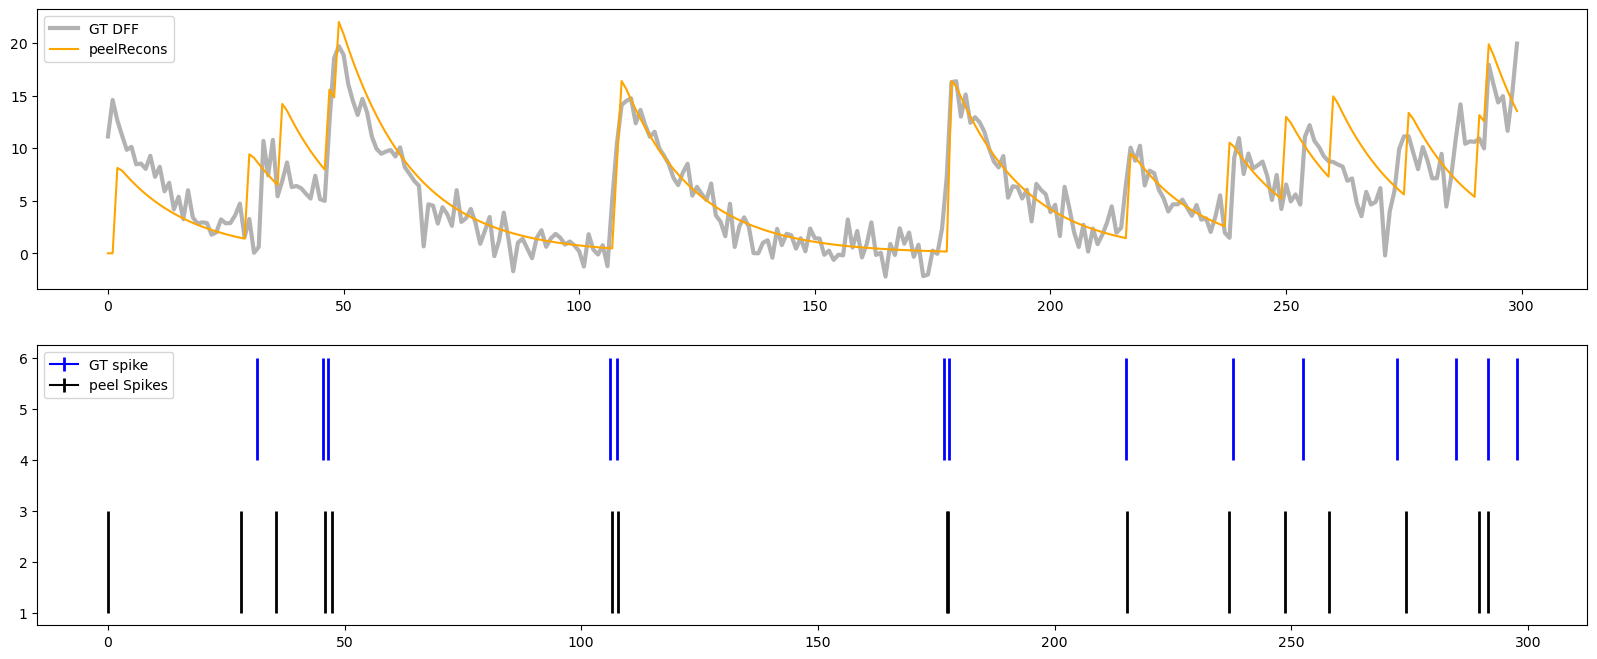

In [6]:
neuronIndex = 8
sMax = math.ceil(dff.iloc[:, neuronIndex].max().max())


# Plot
subplotsNum = 2
fig, (ax1, ax2) = plt.subplots(subplotsNum,1, figsize=(20,4*subplotsNum),facecolor='w', edgecolor='k')

# DFF
ax1.plot(dff.iloc[:, neuronIndex], color='grey', lw=3, alpha=0.6, label='GT DFF')
ax1.plot(dffRecon[neuronIndex], c='orange',lw=1.5, alpha=1, label='peelRecons')
ax1.legend(loc=0)


# spikes
spkTimes = simuObj.spkTimes[neuronIndex]
simuY = 5
spkTimesRecon = spikePredict[neuronIndex]
peelY = 2
for n in range(len(spkTimes)):
    if n==0:
        ax2.errorbar(spkTimes[n]*frameRate, label='GT spike',y=simuY, yerr=1, c='blue', elinewidth=2)
    else:
        ax2.errorbar(spkTimes[n]*frameRate, y=simuY, yerr=1, c='blue', elinewidth=2)

for n in range(len(spkTimesRecon)):
    if n==0:
        ax2.errorbar(spkTimesRecon[n]*frameRate, label='peel Spikes',y=peelY, yerr=1, c='black', elinewidth=2)
    else:
        ax2.errorbar(spkTimesRecon[n]*frameRate, y=peelY, yerr=1, c='black', elinewidth=2)
ax2.legend(loc='upper left')

        
plt.show()

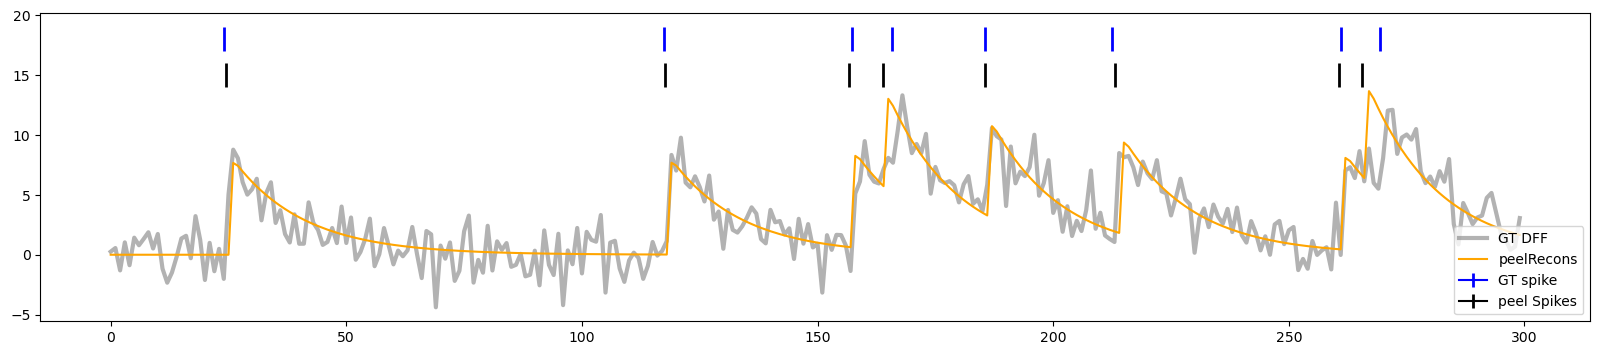

In [7]:
neuronIndex = 1
sMax = math.ceil(dff.iloc[:, neuronIndex].max().max())


# Plot
subplotsNum = 2
fig, ax1 = plt.subplots(figsize=(20,4),facecolor='w', edgecolor='k')

# DFF
ax1.plot(dff.iloc[:, neuronIndex], color='grey', lw=3, alpha=0.6, label='GT DFF')
ax1.plot(dffRecon[neuronIndex], c='orange',lw=1.5, alpha=1, label='peelRecons')


# spikes
spkTimes = simuObj.spkTimes[neuronIndex]
simuY = 18
spkTimesRecon = spikePredict[neuronIndex]
peelY = 15
for n in range(len(spkTimes)):
    if n==0:
        ax1.errorbar(spkTimes[n]*frameRate, label='GT spike',y=simuY, yerr=1, c='blue', elinewidth=2)
    else:
        ax1.errorbar(spkTimes[n]*frameRate, y=simuY, yerr=1, c='blue', elinewidth=2)

for n in range(len(spkTimesRecon)):
    if n==0:
        ax1.errorbar(spkTimesRecon[n]*frameRate, label='peel Spikes',y=peelY, yerr=1, c='black', elinewidth=2)
    else:
        ax1.errorbar(spkTimesRecon[n]*frameRate, y=peelY, yerr=1, c='black', elinewidth=2)
ax1.legend(loc='lower right')

        
plt.show()

#### Zoom In

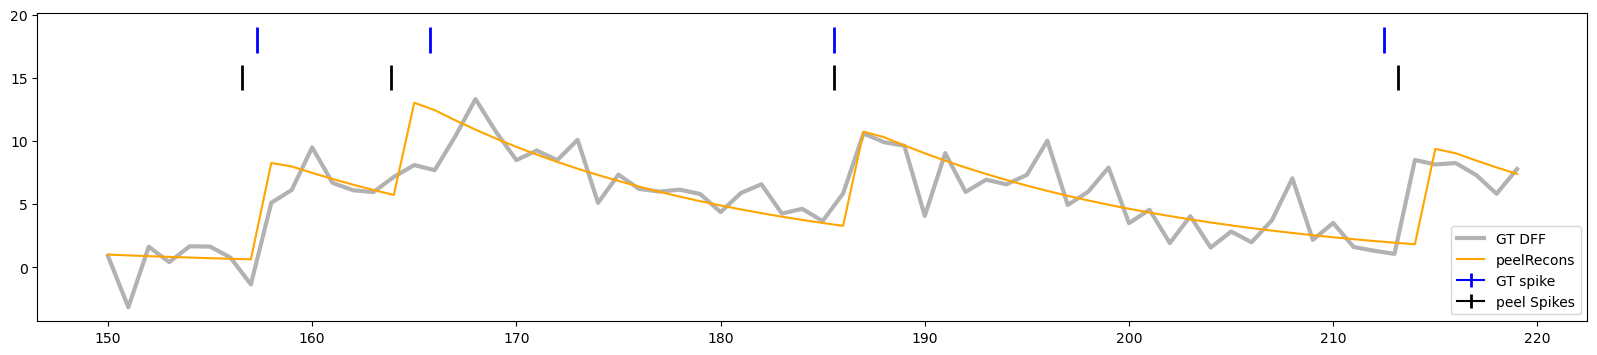

In [8]:
neuronIndex = 1
sMax = math.ceil(dff.iloc[:, neuronIndex].max().max())


# Plot
subplotsNum = 2
fig, ax1 = plt.subplots(figsize=(20,4),facecolor='w', edgecolor='k')

# DFF
ax1.plot(dff.iloc[:, neuronIndex][150:220], color='grey', lw=3, alpha=0.6, label='GT DFF')
ax1.plot(pd.DataFrame(dffRecon).T.iloc[:, neuronIndex][150:220], c='orange',lw=1.5, alpha=1, label='peelRecons')


# spikes
spkTimes = simuObj.spkTimes[neuronIndex]
simuY = 18
spkTimesRecon = spikePredict[neuronIndex]
peelY = 15
for n in range(2, 6):
    if n==2:
        ax1.errorbar(spkTimes[n]*frameRate, label='GT spike',y=simuY, yerr=1, c='blue', elinewidth=2)
    else:
        ax1.errorbar(spkTimes[n]*frameRate, y=simuY, yerr=1, c='blue', elinewidth=2)

for n in range(2, 6):
    if n==3:
        ax1.errorbar(spkTimesRecon[n]*frameRate, label='peel Spikes',y=peelY, yerr=1, c='black', elinewidth=2)
    else:
        ax1.errorbar(spkTimesRecon[n]*frameRate, y=peelY, yerr=1, c='black', elinewidth=2)
ax1.legend(loc='lower right')

        
plt.show()

#### Expand Peeling Process

working on neuron 1
-----------------------------------------------------------------------------
spikeTime at 0.8333333333333334 spike starts at 25 , and check window ends at 40 

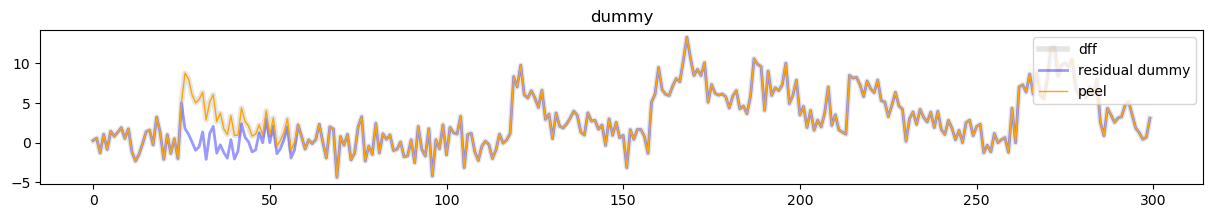

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=0 and check again.


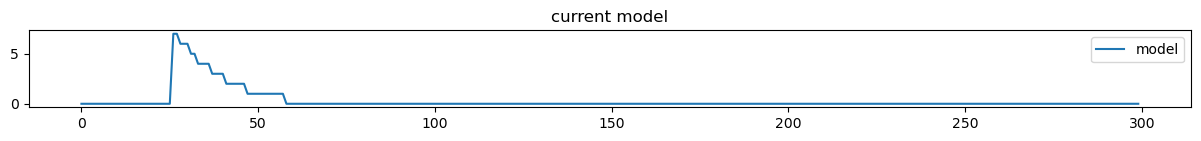

-----------------------------------------------------------------------------
spikeTime at 3.966666666666667 spike starts at 119 , and check window ends at 134 

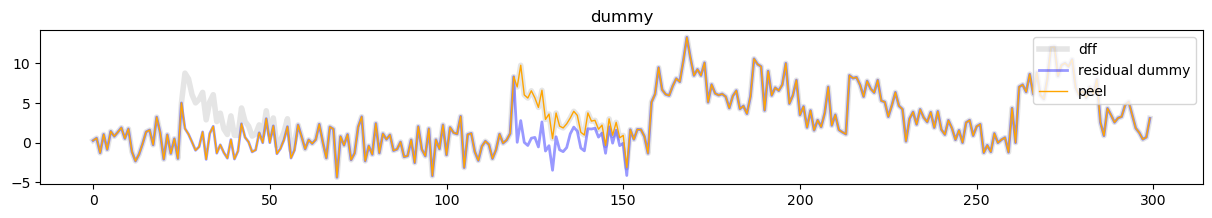

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=0 and check again.


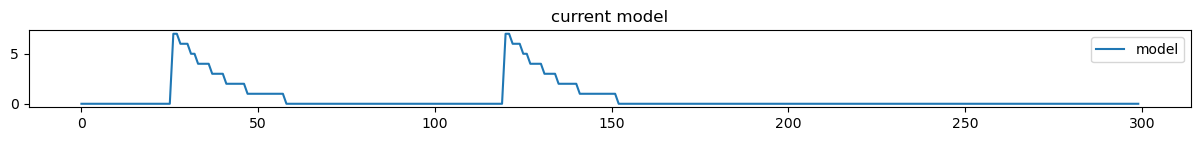

-----------------------------------------------------------------------------
spikeTime at 5.266666666666667 spike starts at 158 , and check window ends at 173 

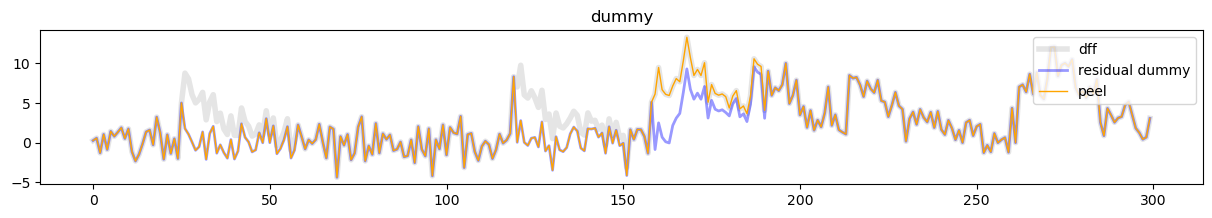

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=0.2667 and check again.


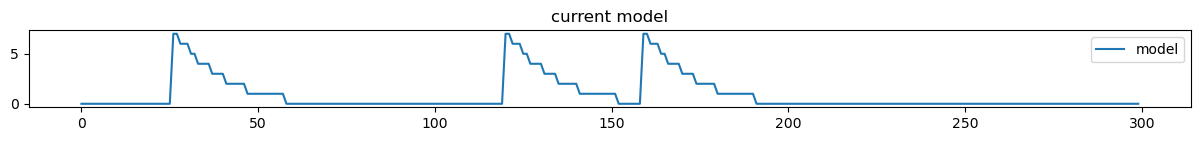

-----------------------------------------------------------------------------
spikeTime at 5.266666666666667 spike starts at 158 , and check window ends at 173 

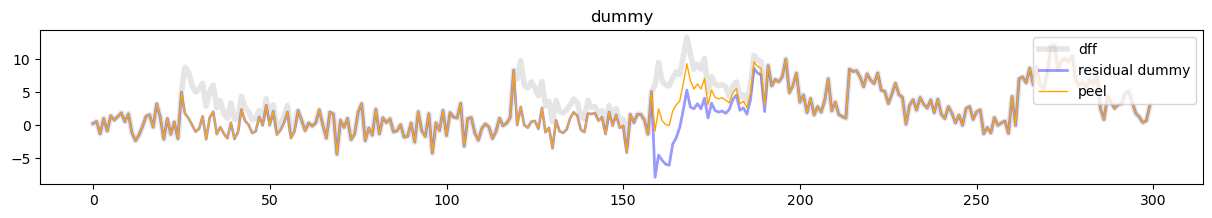

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=5.3333 and check event


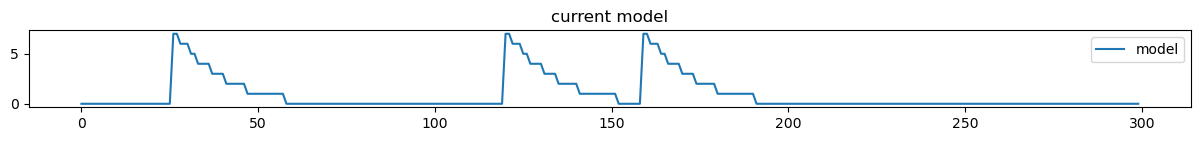

-----------------------------------------------------------------------------
spikeTime at 5.333333333333333 spike starts at 160 , and check window ends at 175 

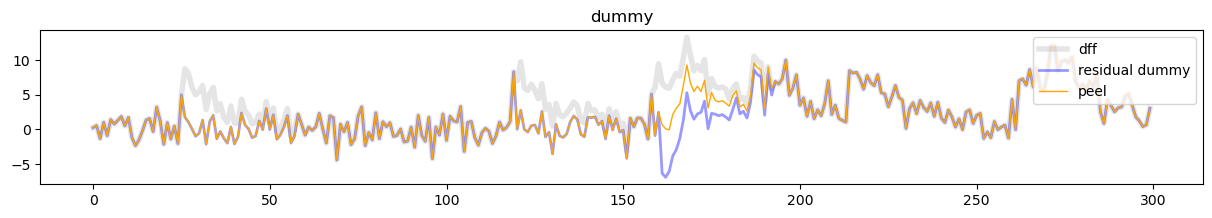

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=0.3333 and check again.


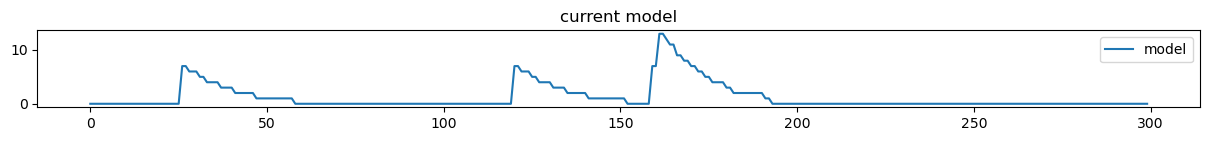

-----------------------------------------------------------------------------
spikeTime at 5.833333333333333 spike starts at 175 , and check window ends at 190 

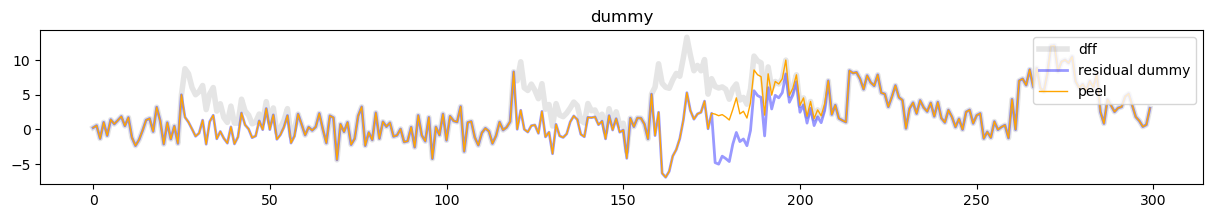

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=5.9 and check event


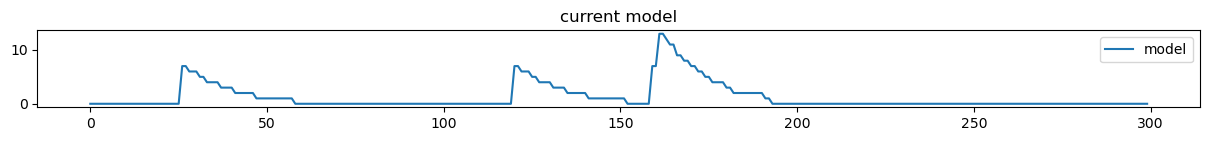

-----------------------------------------------------------------------------
spikeTime at 6.033333333333333 spike starts at 181 , and check window ends at 196 

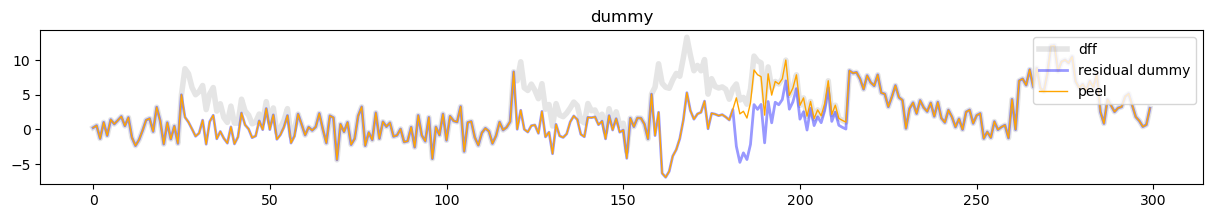

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=1.0333 and check again.


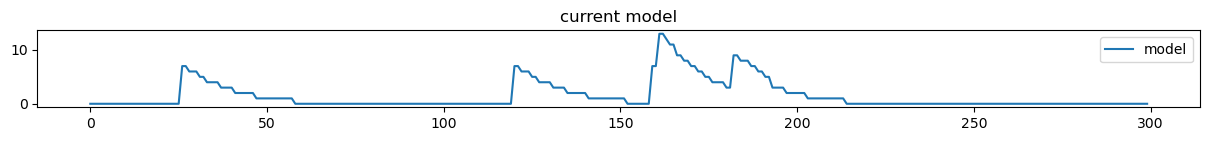

-----------------------------------------------------------------------------
spikeTime at 6.233333333333333 spike starts at 187 , and check window ends at 202 

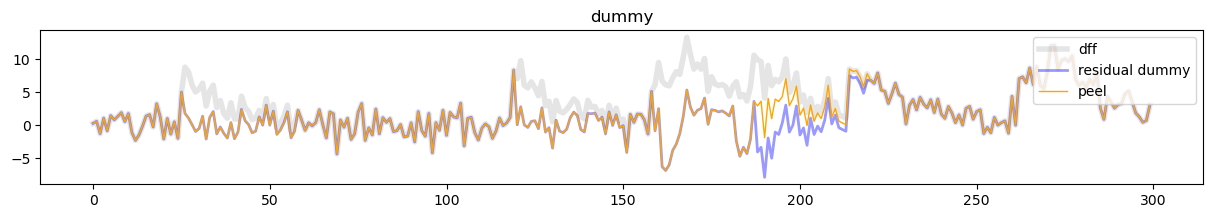

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.3 and check event


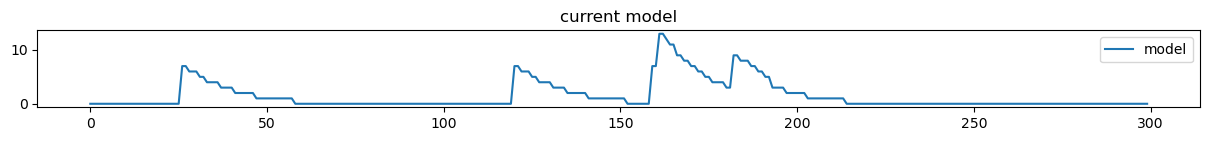

-----------------------------------------------------------------------------
spikeTime at 6.366666666666666 spike starts at 191 , and check window ends at 206 

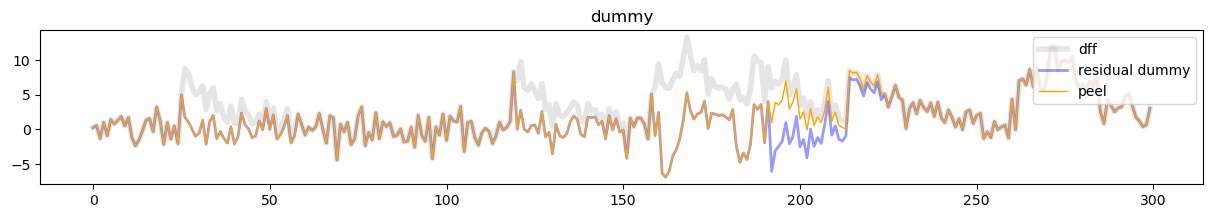

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.4333 and check event


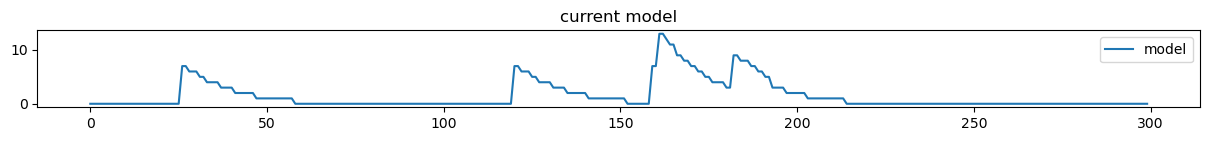

-----------------------------------------------------------------------------
spikeTime at 6.766666666666667 spike starts at 203 , and check window ends at 218 

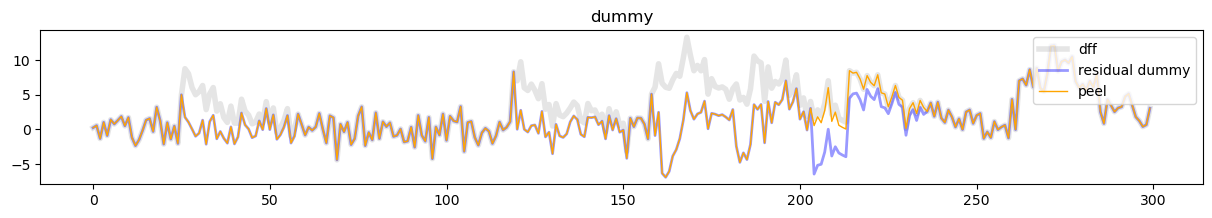

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.8333 and check event


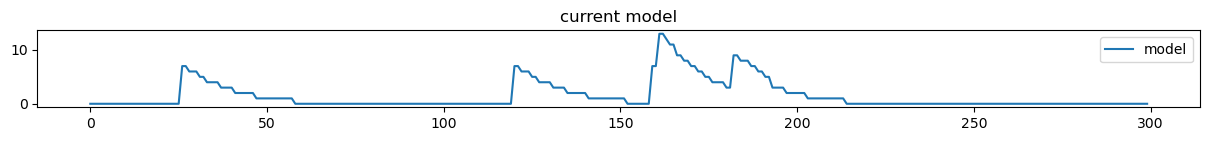

-----------------------------------------------------------------------------
spikeTime at 6.933333333333334 spike starts at 208 , and check window ends at 223 

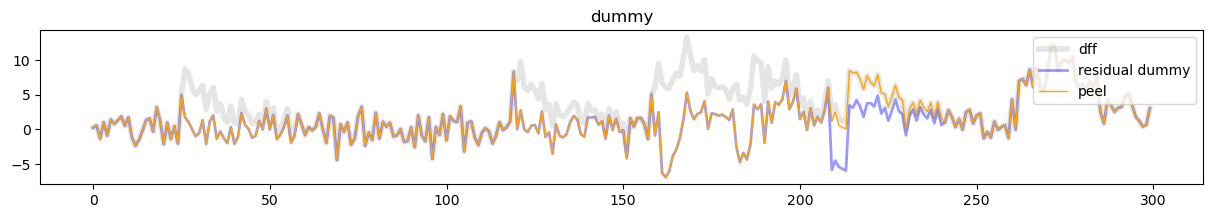

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=1.9333 and check again.


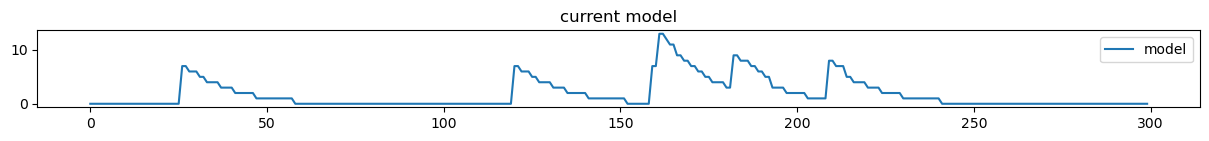

-----------------------------------------------------------------------------
spikeTime at 6.233333333333333 spike starts at 187 , and check window ends at 202 

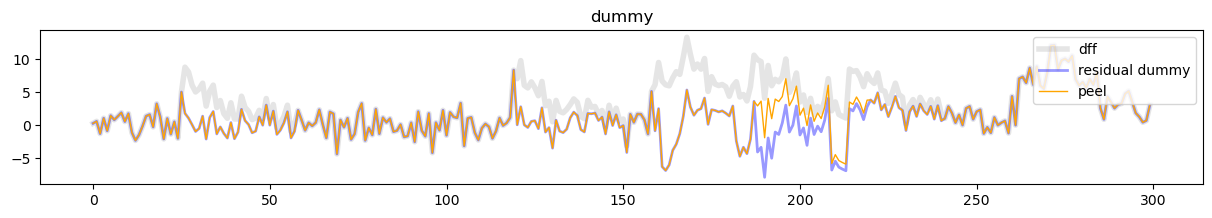

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.3 and check event


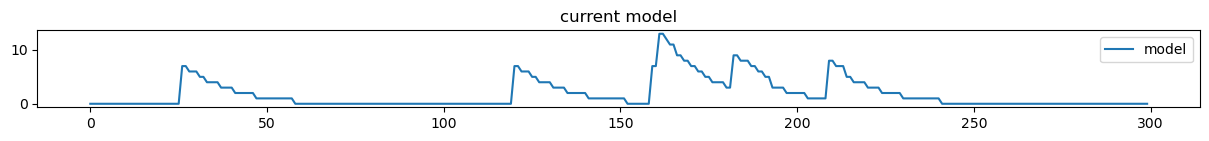

-----------------------------------------------------------------------------
spikeTime at 6.366666666666666 spike starts at 191 , and check window ends at 206 

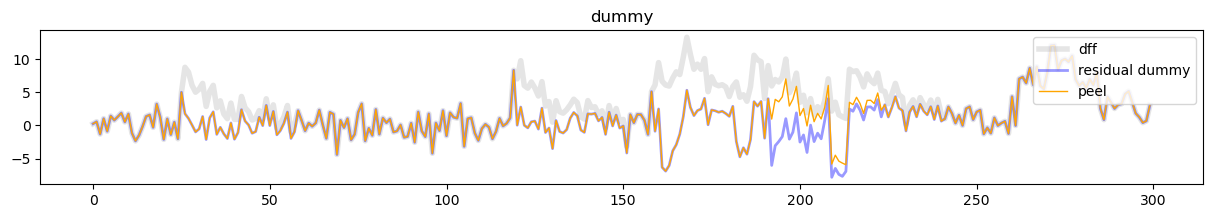

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.4333 and check event


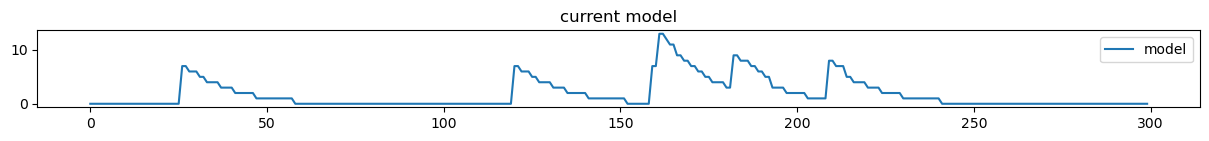

-----------------------------------------------------------------------------
spikeTime at 8.666666666666666 spike starts at 260 , and check window ends at 275 

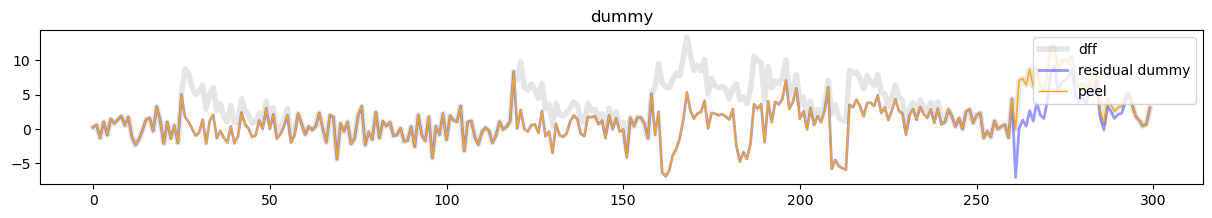

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=3.6667 and check again.


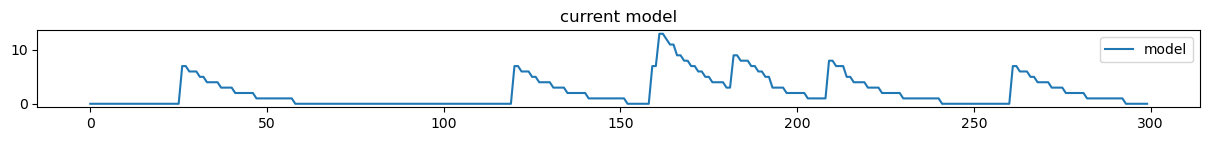

-----------------------------------------------------------------------------
spikeTime at 6.233333333333333 spike starts at 187 , and check window ends at 202 

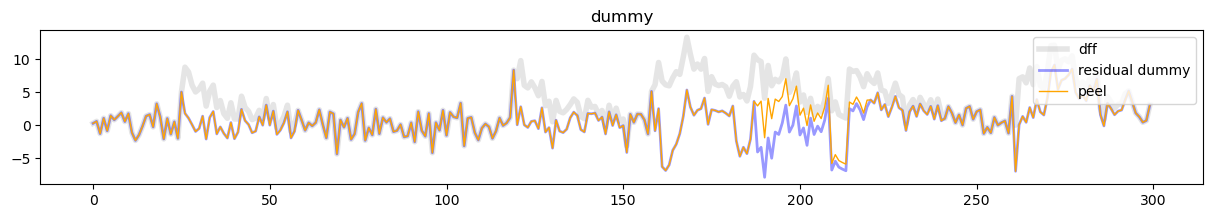

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.3 and check event


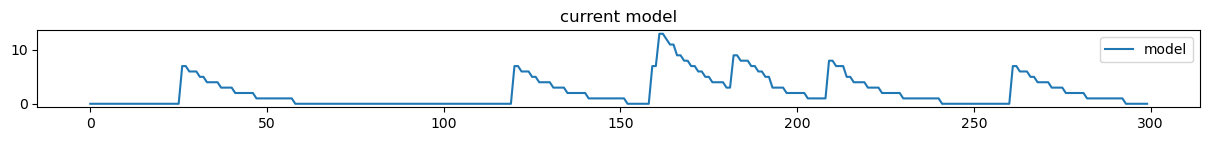

-----------------------------------------------------------------------------
spikeTime at 6.366666666666666 spike starts at 191 , and check window ends at 206 

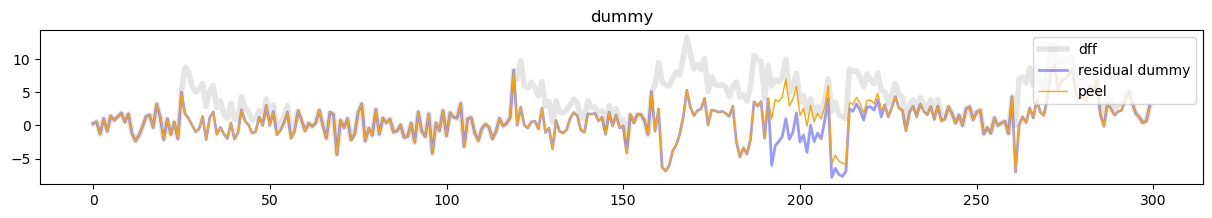

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.4333 and check event


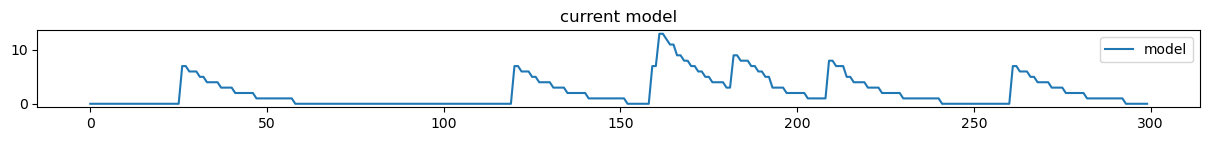

-----------------------------------------------------------------------------
spikeTime at 8.9 spike starts at 267 , and check window ends at 282 

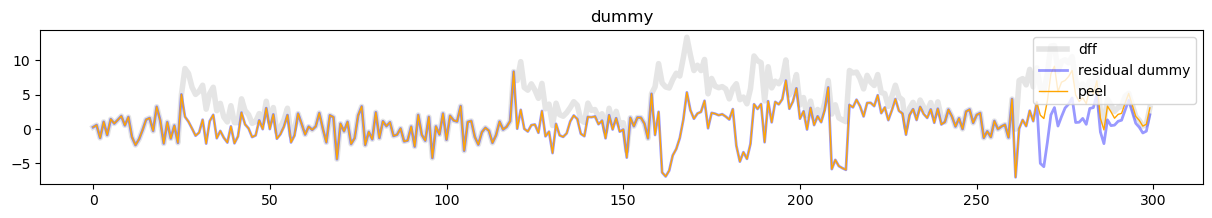

dummy_checkWin Integral>negIntegral, real spike, peel off singleTransient
step back to nexttim=3.9 and check again.


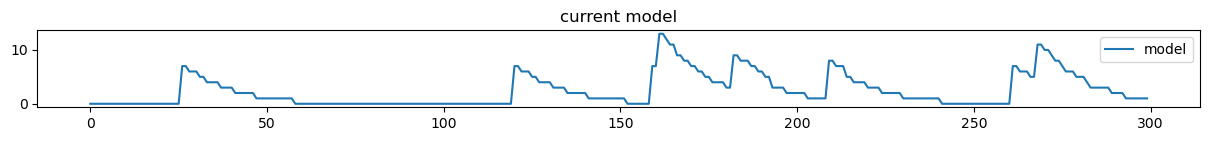

-----------------------------------------------------------------------------
spikeTime at 6.233333333333333 spike starts at 187 , and check window ends at 202 

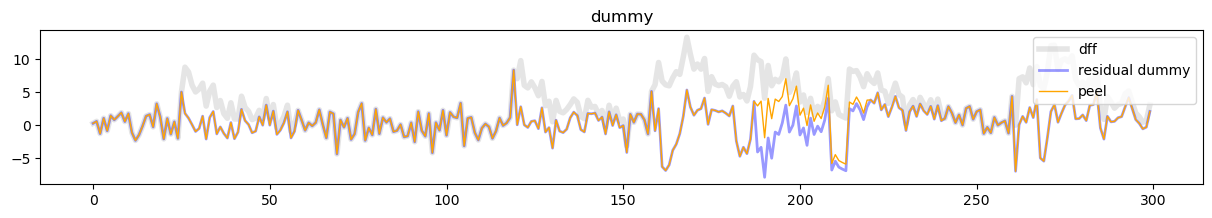

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.3 and check event


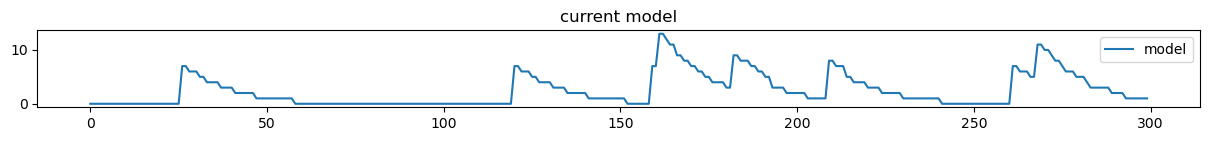

-----------------------------------------------------------------------------
spikeTime at 6.366666666666666 spike starts at 191 , and check window ends at 206 

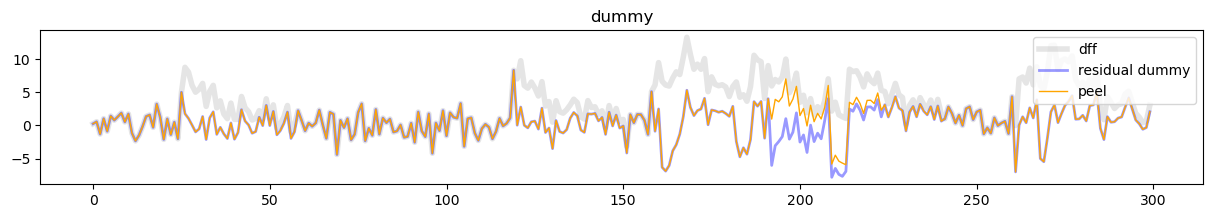

dummy_checkWin Integral<=negIntegral. Revoke spike, numspikes, and singleTransient in data.model
step forward to nexttim=6.4333 and check event


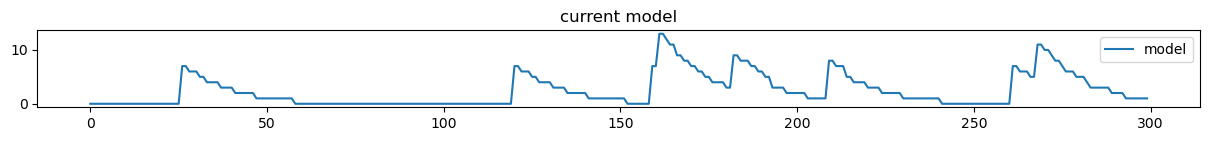

In [5]:
# peel

m = 1
print('working on neuron', m)

# parameters
dffCC = simuObj.sampledFluor[m] # dffCC = simuObj.dff[m]
simuCC = simuPara.get_valuesByIndex('simulation', m)
peelParamCC = peelParams(dffCC, params_dict=simuCC)

# peel
peelObj = peelReconstr(dffCC, simuObj.xSampled, simuObj.spkTimes[m], verbose=True, params=peelParamCC)
peelObj_dic['neuron'+str(m)] = peelObj


peel_m = peelObj.peel
dffRecon_m = peelObj.dffRecon
spikePredict_m = peelObj.spkTimesRecon



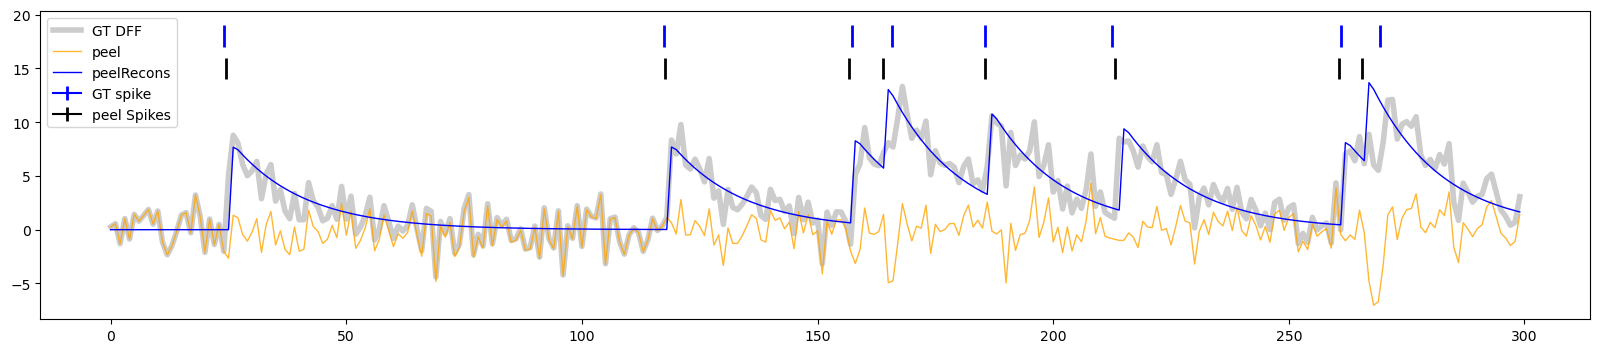

In [11]:
neuronIndex = 1
sMax = math.ceil(dff.iloc[:, neuronIndex].max().max())


# Plot
subplotsNum = 2
fig,ax1 = plt.subplots( figsize=(20,4),facecolor='w', edgecolor='k')

# DFF
ax1.plot(dff.iloc[:, neuronIndex], color='grey', lw=4, alpha=0.4, label='GT DFF')
ax1.plot(peelObj.params.data['peel'], c='orange',lw=1, alpha=0.8, label='peel')
ax1.plot(dffRecon_m, c='blue',lw=1, alpha=1, label='peelRecons')
    
    
# spikes
spkTimes = simuObj.spkTimes[neuronIndex]
simuY = 18
spkTimesRecon = spikePredict[neuronIndex]
peelY = 15
for n in range(len(spkTimes)):
    if n==0:
        ax1.errorbar(spkTimes[n]*frameRate, label='GT spike',y=simuY, yerr=1, c='blue', elinewidth=2)
    else:
        ax1.errorbar(spkTimes[n]*frameRate, y=simuY, yerr=1, c='blue', elinewidth=2)

for n in range(len(spkTimesRecon)):
    if n==0:
        ax1.errorbar(spkTimesRecon[n]*frameRate, label='peel Spikes',y=peelY, yerr=1, c='black', elinewidth=2)
    else:
        ax1.errorbar(spkTimesRecon[n]*frameRate, y=peelY, yerr=1, c='black', elinewidth=2)
ax1.legend(loc='upper left')
    
    
plt.show()